In [16]:
# https://arxiv.org/pdf/cond-mat/0101295.pdf
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import uniform, bernoulli
import numpy as np
from ipywidgets import interact, interactive, fixed
from IPython.display import display
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
%matplotlib inline
n=0
def gen2dLattice(n):
    '''Create a 2n by 2n square graph'''
    return nx.grid_2d_graph(range(-n,n+1),range(-n,n+1))

def percGraph(n):
    G = gen2dLattice(n)
    num_edges = nx.number_of_edges(G)
    unifRvs = uniform.rvs(size=num_edges) #Create Uniform Rv for each edge
    dictUnifRvs = {coord:rv for coord,rv in zip(G.edges,iter(unifRvs))} # Dictionary from edges to their unif rv
    nx.set_edge_attributes(G,dictUnifRvs,name="unifRv") # binds the unif rvs to the edges in the graph 
    GAug = G.copy()
    GAug.add_node('s') #create aug graph with s and f nodes which connect to the left an right sides resp
    GAug.add_node('f')
    for i in range(-n,n+1):
        GAug.add_edge('s',(-n,i))
        GAug.add_edge((n,i),'f')
    return G , GAug

def find_crossing_path(openEdges,GAug) -> list:
    '''finds left/right crossing by open edges if one exists
    Returns: List of edges on the path
    ''' # find the subgraph of open edges plus the aux left right edges
    GOpen = nx.edge_subgraph(GAug,list(GAug.edges('f')) + list(GAug.edges('s')) + [(e[0],e[1]) for e in openEdges])
    edgepath = []
    try:
        openPaths = nx.algorithms.shortest_paths.bidirectional_shortest_path(GOpen,'s','f')
    except:
        openPaths = []
    for i in range(len(openPaths)): #Convert from list of nodes to list of edges
        edgepath.append((openPaths[i-1],openPaths[i]))
    openPaths = edgepath
    return openPaths

setup = interactive(percGraph,n=(1,50,1))


In [17]:
display(setup)
@interact(G=fixed(setup.result[0]),p=(0,1,0.01),findCrossing = True)
def percolate(G,p,findCrossing = True): 
    '''finds open/closed edges in G for a given p and displays it'''
    G, GAug = setup.result
    openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p] #List of edges whose associated Uniform Rv has value <= p 
    closedEdges = [e for e in G.edges(data=True) if e[2]['unifRv']>p]
    pos = {(x,y):(x,y) for x,y in G.nodes()} #postions nodes in the plane in the normal way
    if findCrossing:
        path = find_crossing_path(openEdges,GAug)
    plt.figure(figsize=(8,8))
    nx.draw(G, pos= pos, node_size=0, edgelist=closedEdges,edge_color='grey',width=0.5, with_labels=False) #draw closed edges
    nx.draw(G, pos= pos, node_size=0, edgelist=openEdges,edge_color='red', with_labels=False) #draw open edges
    if findCrossing and path:
        path.pop(0)
        path.pop(0)
        path.pop(-1)
        nx.draw(G, pos= pos, node_size=0, edgelist=path,edge_color='green',width=1.5, with_labels=False) #draw open path
    plt.show()



interactive(children=(IntSlider(value=25, description='n', max=50, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(FloatSlider(value=0.0, description='p', max=1.0, step=0.01), Checkbox(value=True, descri…

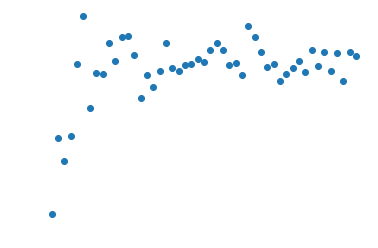

In [23]:
#Find percolation threshold for different size boxes
def is_crossing_path(openEdges,GAug) -> list:
    '''finds if a left/right crossing exists
    Returns: the path
    ''' # find the subgraph of open edges plus the aux left right edges
    GOpen = nx.edge_subgraph(GAug,list(GAug.edges('f')) + list(GAug.edges('s')) + [(e[0],e[1]) for e in openEdges])
    openPaths = nx.all_simple_paths(GOpen,source='s', target='f',cutoff='1')
    return next(openPaths, None)

def find_threshold(i):
    '''Finds the threshold for a left right crossing on a 2i x 2i box'''
    G, GAug = percGraph(i)
    p = 0.5
    openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p]
    crossing = find_crossing_path(openEdges, GAug)
    if len(crossing) == 0:
        while len(crossing) == 0:
            #print(f'p= {p}, len= {len(crossing)}')
            p += 0.0001
            openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p]
            crossing  = find_crossing_path(openEdges, GAug)
    else:
        while len(crossing) > 0:
            p -= 0.0001
            openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p]
            crossing  = find_crossing_path(openEdges, GAug)
    return p

def find_threshold_binary_search(i):
    '''Finds the threshold for a left right crossing on a 2i x 2i box'''
    G, GAug = percGraph(i)
    lo=0
    hi=1
    p = (lo+hi)/2
    openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p]
    crossing = find_crossing_path(openEdges, GAug)
    while lo <= hi:
        p = (lo+hi)/2
        
        openEdges = [e for e in G.edges(data=True) if e[2]['unifRv']<=p]
        crossing = len(find_crossing_path(openEdges, GAug))
        if crossing == 0:
            
            pAlt = p + 0.0001
            openEdgesAlt = [e for e in G.edges(data=True) if e[2]['unifRv']<=pAlt]
            crossingAlt = len(find_crossing_path(openEdgesAlt, GAug))
            if crossingAlt >0:
                return pAlt
            else:
                
                lo = pAlt    
        else:
            
            pAlt = p - 0.0001
            openEdgesAlt = [e for e in G.edges(data=True) if e[2]['unifRv']<=pAlt]
            crossingAlt = len(find_crossing_path(openEdgesAlt, GAug))
            if crossingAlt ==0:
                return p
            else:
                
                hi = pAlt
    print('something wrong')
    return None

thresholds = [find_threshold_binary_search(i) for i in range(1,50)]
plt.scatter(range(1,50),thresholds)

